In [17]:
import sys
sys.path.append("..")

In [18]:
import default_config as cfg
import local_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)

In [19]:
import dataset_functions
import models.six_stage_linear_model as model
import dataset_builder
import utils
import tensorflow as tf
import numpy as np
import visualizations as v
import matplotlib.pyplot as plt


In [20]:
model_ds=model.ModelDatasetComponent(cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
tfrecord_files_valid.sort()
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)
it=iter(dsv)
st=next(it)

Retrieving TFrecords from: C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords/validation
Found the following validation TFrecords:
 C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\validation-001.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\validation-002.tfrecords
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


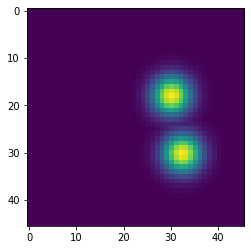

In [21]:
kpts=st[1][5][0]
ex1=kpts[...,0]
ex2=kpts[...,7]

comp=np.maximum(ex1,ex2)
plt.imshow(comp)

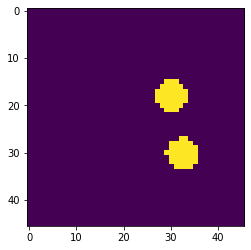

In [22]:
import cv2
input_thershold=comp>0.5
plt.imshow(input_thershold)

In [ ]:
class BoundryWalker:
    steps=np.array((
            (1,0)
            ,(0,1)
            ,(-1,0)
            ,(0,-1)
            ),dtype=np.int) #CCW orientation
    
    def __init__(self,starting_pos,ocean,visited,entry_direction):
        self.starting_pos=starting_pos
        self.current_pos=starting_pos
        self.visited=visited
        self.previous_move=entry_direction 
        self.ocean=ocean
        self.boundry=[]
        
    def check_move(self,move):
        test_pos=self.current_pos+self.steps[move]
        return bool(self.ocean[test_pos[0],test_pos[1]])
        
    def mark_island_boundry(self):
        while True: #fix 
            move=(self.previous_move+3)%4 #get the next move CCW from reverse direction
            while not self.check_move(move): #check all directions arond, going CCW
                move=(move+1)%4
            self.current_pos+=self.steps[move] #move
            self.previous_move=move
            
            self.visited[self.current_pos[0],self.current_pos[1]]=True
            self.boundry.append(self.current_pos)
            print(self.current_pos,flush=1)
            if all(self.current_pos == self.starting_pos):
                break
        return self.boundry
    
visited=np.zeros((comp.shape),dtype=np.bool)
islands=[]
for x in range(46):
    for y in range(46):
        if input_thershold[y,x] and not visited[y,x]:
            bw=BoundryWalker(np.array((y,x)),input_thershold,visited,0)
            islands.append(bw.mark_island_boundry())
            
        visited[y,x]=True

[18 27]
[19 28]
